# S4E4 Outliers Analysis

## Imports

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

# Load the data
train = pd.read_csv('data/train.csv', index_col='id')
test = pd.read_csv('data/test.csv', index_col='id')
original = pd.read_csv('data/abalone.data')
original.columns = train.columns 
original.index.name = 'id'

## Preliminary Analysis

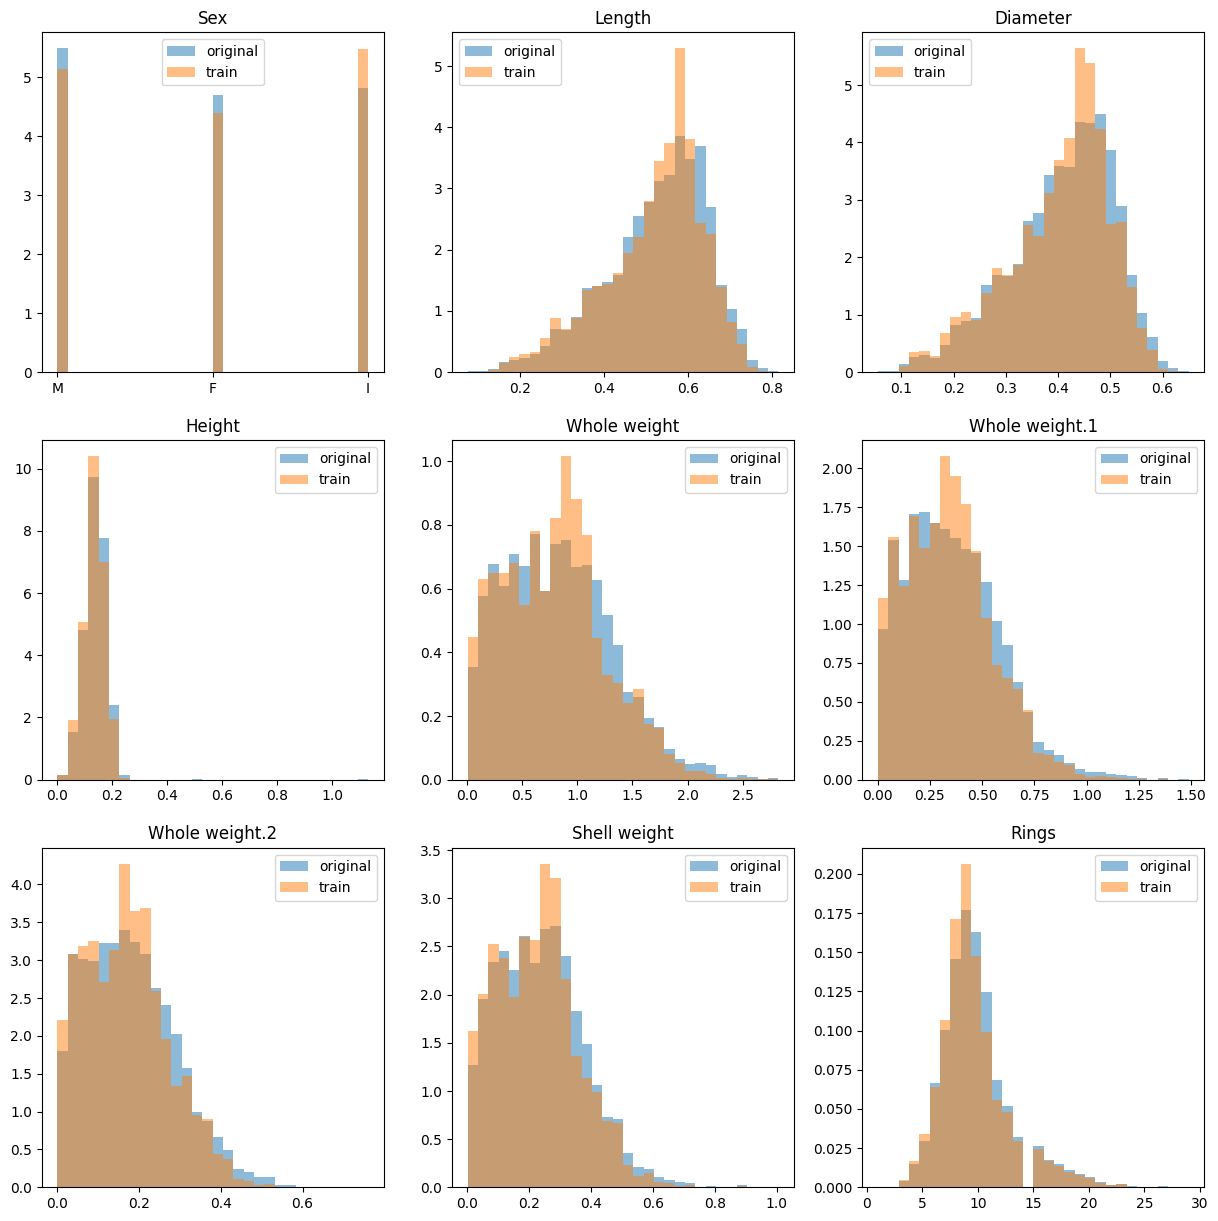

In [2]:
# plot the histogram of the original data and the training data 
# in the same histogram with all the features
def custom_hist(original, train):
    fig, ax = plt.subplots(3, 3, figsize=(15, 15))
    for i, col in enumerate(train.columns):
        ax[i//3, i%3].hist(original[col], bins=30, alpha=0.5, label='original', density=True)
        ax[i//3, i%3].hist(train[col], bins=30, alpha=0.5, label='train', density=True)
        ax[i//3, i%3].set_title(col)
        ax[i//3, i%3].legend()
    plt.show()

custom_hist(original, train)

As we can see, the generated data has a similar distribution of the original data. However, we can see the histogram of the Height feature is a bit odd with some outliers. Let's analyze the outliers in the Height feature.

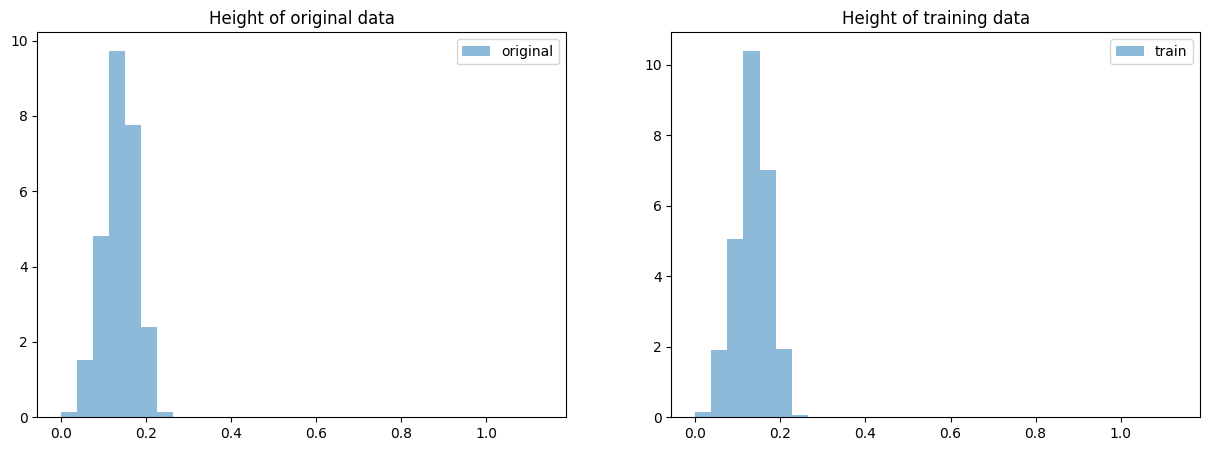

In [3]:
# plot the histogram of the original data and the training data of Height 

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].hist(original['Height'], bins=30, alpha=0.5, label='original', density=True)
ax[0].set_title('Height of original data')
ax[0].legend()
ax[1].hist(train['Height'], bins=30, alpha=0.5, label='train', density=True)
ax[1].set_title('Height of training data')
ax[1].legend()

In [4]:
# remove all the outliers (Heihgt > 0.3) in the original data
original_h = original[original['Height'] <= 0.3]
train_h = train[train['Height'] <= 0.3]


(4176, 9) (90615, 9)
(4163, 9) (90487, 9)


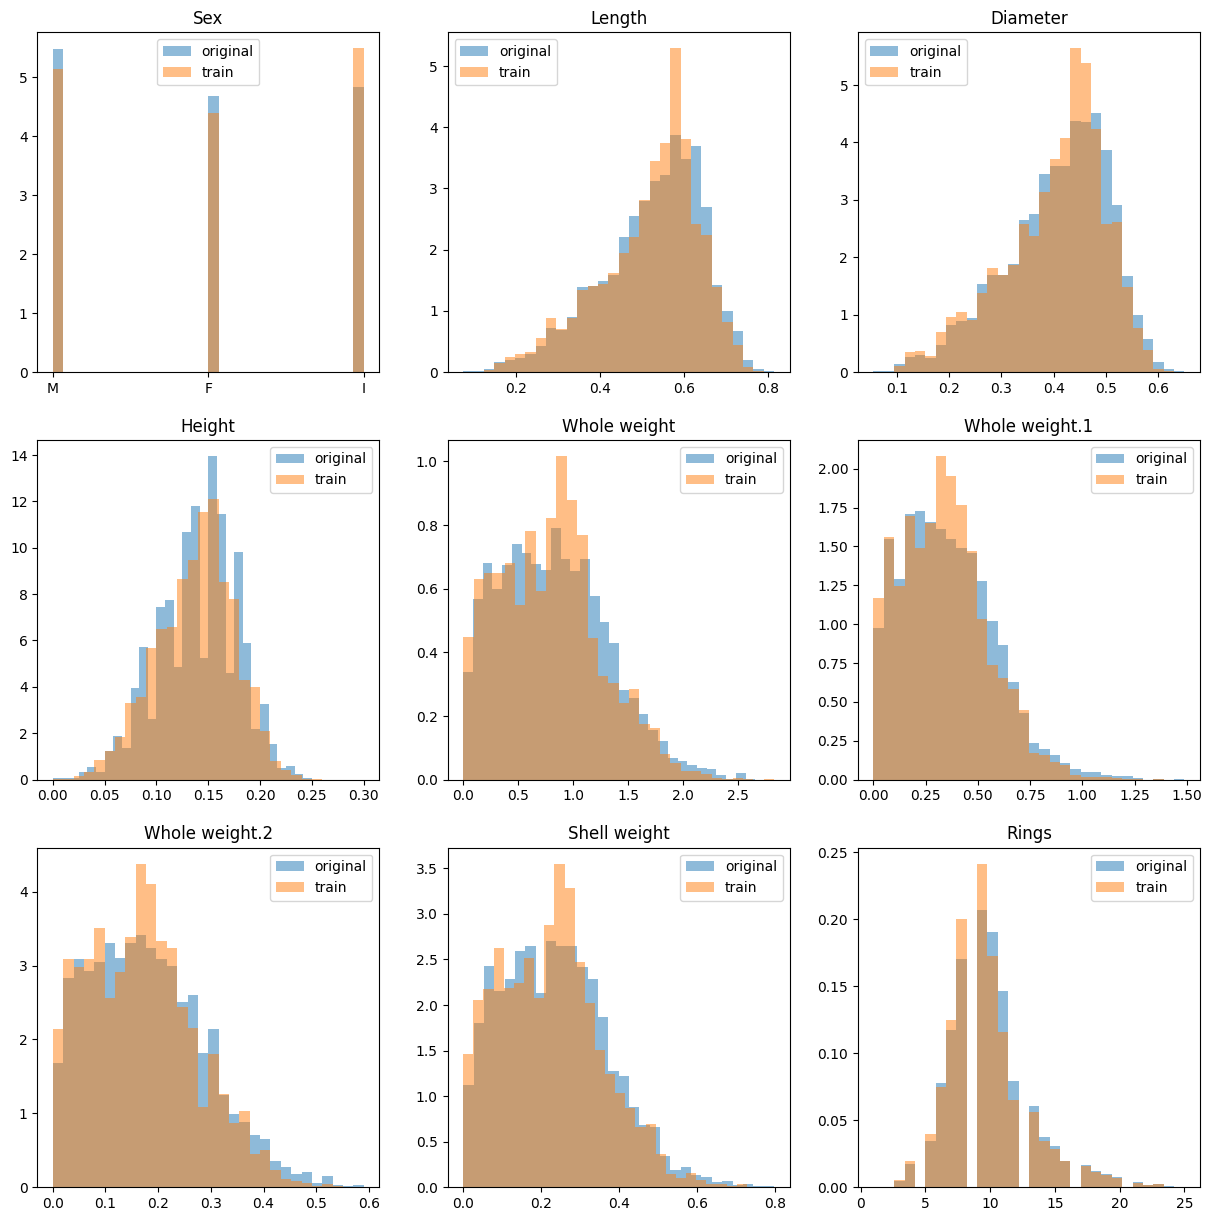

In [5]:
# in addition to that, there are also some not very significant outliers in the original data

original_hr = original_h[original_h['Rings'] <= 25]
train_hr = train_h[train_h['Rings'] <= 25]
original_hrw = original_hr[original_hr['Whole weight.2'] <= 0.6]
train_hrw = train_hr[train_hr['Whole weight.2'] <= 0.6]
original_hrws = original_hrw[original_hrw['Shell weight'] <= 0.8]
train_hrws = train_hrw[train_hrw['Shell weight'] <= 0.8]

print(original.shape, train.shape)
print(original_hrws.shape, train_hrws.shape)

custom_hist(original_hrws, train_hrws)

## Comparison

In [6]:
# combine the original data and the training data 
combined = pd.concat([train, original], axis=0)
new_combined = pd.concat([train_hrws, original_hrws], axis=0)

# save the new dataset 
new_combined.to_csv('data/reduced_new_train.csv')

X = combined.drop('Rings', axis=1)
y = combined['Rings']
new_X = new_combined.drop('Rings', axis=1)
new_y = new_combined['Rings']

# one hot encode each of them 
X = pd.get_dummies(X)
new_X = pd.get_dummies(new_X)

In [7]:
# a simple lightgbm model with 10 fold cross validation 
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

model = LGBMRegressor(n_estimators=360, max_depth=14, learning_rate=0.02002177841890934, 
                          subsample=0.7312027119141618, colsample_bytree=0.6574736218784601, 
                          min_child_weight=48, num_leaves=180, random_state=42, verbose=-1, device='cuda')

scores = cross_val_score(model, X, y, cv=10, scoring=rmsle_scorer)
print("RMSLE: %0.4f (+/- %0.4f)" % (-scores.mean(), scores.std() * 2))

model = LGBMRegressor(n_estimators=360, max_depth=14, learning_rate=0.02002177841890934, 
                          subsample=0.7312027119141618, colsample_bytree=0.6574736218784601, 
                          min_child_weight=48, num_leaves=180, random_state=42, verbose=-1, device='cuda')
scores = cross_val_score(model, new_X, new_y, cv=10, scoring=rmsle_scorer)
print("RMSLE: %0.4f (+/- %0.4f)" % (-scores.mean(), scores.std() * 2))


/usr/local/lib/python3.10/dist-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 14.0.1.dev0+gba5374836.d20240125. Please consider upgrading.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# read in test data 
test = pd.read_csv('data/test.csv', index_col='id')
X_test = pd.get_dummies(test)

model = LGBMRegressor(n_estimators=360, max_depth=14, learning_rate=0.02002177841890934, 
                          subsample=0.7312027119141618, colsample_bytree=0.6574736218784601, 
                          min_child_weight=48, num_leaves=180, random_state=42, verbose=-1, device='gpu')
model.fit(new_X, new_y)
predictions = model.predict(X_test)
submission = pd.DataFrame({'id': X_test.index, 'Rings': predictions})
submission.to_csv('submissions.csv', index=False)